In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
class AccuracyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")
        if accuracy is not None and val_accuracy is not None:
            if accuracy > 0.92 and val_accuracy > 0.92:
                print("\nTraining stopped as accuracy and validation accuracy reached above 87%")
                self.model.stop_training = True

In [37]:
def image_augmentation(images, labels, num_augmentations=5):
    augmented_images = []
    augmented_labels = []

    data_augmentation = ImageDataGenerator(
        rotation_range=40,
        zoom_range=0.2,
        shear_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.2, 1.0],
        fill_mode='nearest',
        rescale=1.0 / 255,
    )

    for i in range(num_augmentations):
        augmented_images.extend(data_augmentation.flow(images, batch_size=len(images), shuffle=False).next())
        augmented_labels.extend(labels)

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.uint8)
        
    return augmented_images, augmented_labels

In [38]:
# Check the number of images in each category
train_dir = 'skin2_split/train/'
num_normal_train = len(os.listdir(os.path.join(train_dir, 'normal')))
num_dry_train = len(os.listdir(os.path.join(train_dir, 'kering')))
num_oily_train = len(os.listdir(os.path.join(train_dir, 'berminyak')))
print("===TRAIN===")
print("Number of normal images:", num_normal_train)
print("Number of dry images:", num_dry_train)
print("Number of oily images:", num_oily_train)

val_dir = 'skin2_split/val/'
num_normal_val = len(os.listdir(os.path.join(val_dir, 'normal')))
num_dry_val = len(os.listdir(os.path.join(val_dir, 'kering')))
num_oily_val = len(os.listdir(os.path.join(val_dir, 'berminyak')))
print("\n===VAL===")
print("Number of normal images:", num_normal_val)
print("Number of dry images:", num_dry_val)
print("Number of oily images:", num_oily_val)

===TRAIN===
Number of normal images: 340
Number of dry images: 323
Number of oily images: 335

===VAL===
Number of normal images: 86
Number of dry images: 84
Number of oily images: 84


In [39]:
# Create dataframes for train and validation data
data_train = []
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    for img in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img)
        data_train.append((img_path, category))

train_df = pd.DataFrame(data_train, columns=['Path', 'Label'])

data_val = []
for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    for img in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img)
        data_val.append((img_path, category))

val_df = pd.DataFrame(data_val, columns=['Path', 'Label'])


In [40]:
# Load training images into numpy arrays
def load_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = row['Path']
        label = row['Label']
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(label)
    images = np.array(images, dtype=np.float32)
    labels = pd.get_dummies(labels).values
    return images, labels

train_images, train_labels = load_images(train_df)
val_images, val_labels = load_images(val_df)

In [41]:
# Apply image augmentation
augmented_train_images, augmented_train_labels = image_augmentation(
    train_images, train_labels, num_augmentations=5)

In [42]:
# Use ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow(
    val_images,
    val_labels,
    batch_size=32
)

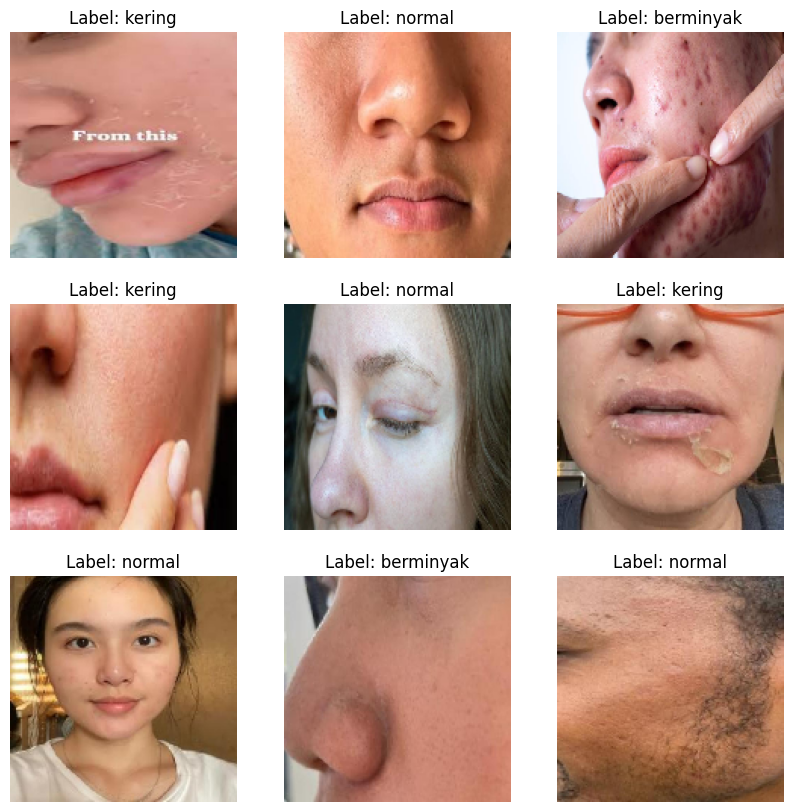

In [43]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    random_idx = random.randint(0, len(train_df) - 1)
    random_img_path = train_df.iloc[random_idx]['Path']
    random_img_label = train_df.iloc[random_idx]['Label']
    random_img = load_img(random_img_path, target_size=(150, 150))
    plt.imshow(random_img)
    plt.title(f"Label: {random_img_label}")
    plt.axis('off')
plt.show()

In [44]:
# plt.figure(figsize=(8, 6))
# sns.countplot(data=train_df, x='Label')
# plt.title('Train Labels Distribution')
# plt.show()

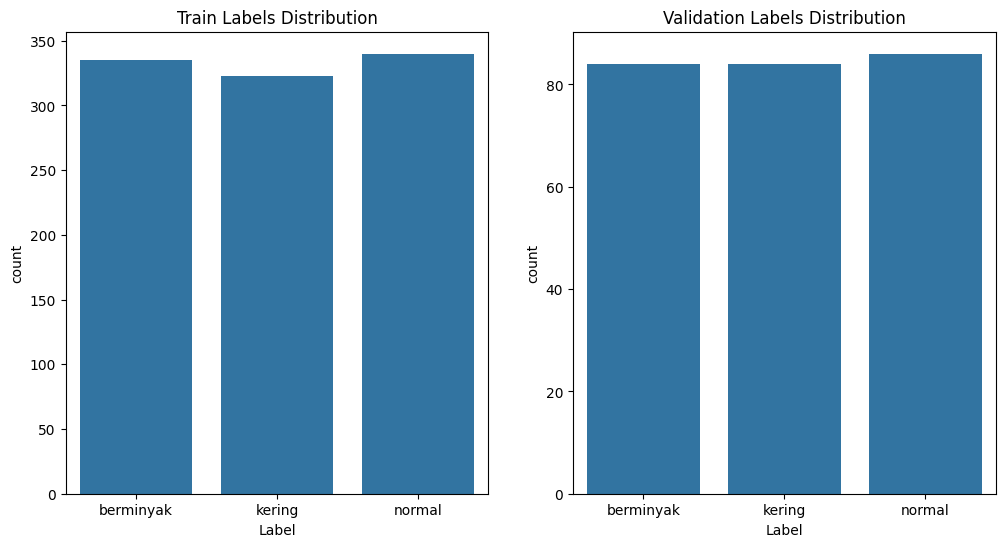

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='Label')
plt.title('Train Labels Distribution')
plt.subplot(1, 2, 2)
sns.countplot(data=val_df, x='Label')
plt.title('Validation Labels Distribution')
plt.show()

In [46]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=40,
#     zoom_range=0.2,
#     shear_range=0.2,
#     height_shift_range=0.2,
#     width_shift_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.2, 1.0],
#     fill_mode='nearest',
#     rescale=1.0 / 255,
# )

# val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [47]:
# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='Path',
#     y_col='Label',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='categorical'
# )

# val_generator = val_datagen.flow_from_dataframe(
#     dataframe=val_df,
#     x_col='Path',
#     y_col='Label',
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='categorical'
# )

In [48]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(train_labels.shape[1], activation='softmax')
])

In [49]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Train the model with the callback
callback = AccuracyStoppingCallback()

In [51]:
# Train the model
history = model.fit(
    augmented_train_images, augmented_train_labels,
    epochs=20,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[callback]

)

Epoch 1/20
156/156 [==============================] - 304s 2s/step - loss: 1.5706 - accuracy: 0.3786 - val_loss: 1.3178 - val_accuracy: 0.3307
Epoch 2/20
156/156 [==============================] - 311s 2s/step - loss: 1.2557 - accuracy: 0.4251 - val_loss: 1.3492 - val_accuracy: 0.3307
Epoch 3/20
156/156 [==============================] - 310s 2s/step - loss: 1.1158 - accuracy: 0.4681 - val_loss: 1.2495 - val_accuracy: 0.3976
Epoch 4/20
156/156 [==============================] - 767s 5s/step - loss: 1.0207 - accuracy: 0.5028 - val_loss: 0.9763 - val_accuracy: 0.5157
Epoch 5/20
156/156 [==============================] - 310s 2s/step - loss: 0.9530 - accuracy: 0.5433 - val_loss: 1.0827 - val_accuracy: 0.4213
Epoch 6/20
156/156 [==============================] - 311s 2s/step - loss: 0.9014 - accuracy: 0.5788 - val_loss: 0.9230 - val_accuracy: 0.5945
Epoch 7/20
156/156 [==============================] - 534s 3s/step - loss: 0.8712 - accuracy: 0.5932 - val_loss: 1.1534 - val_accuracy: 0.5157

In [ ]:
# Save the trained model to a file
model.save('model_v1.h5')

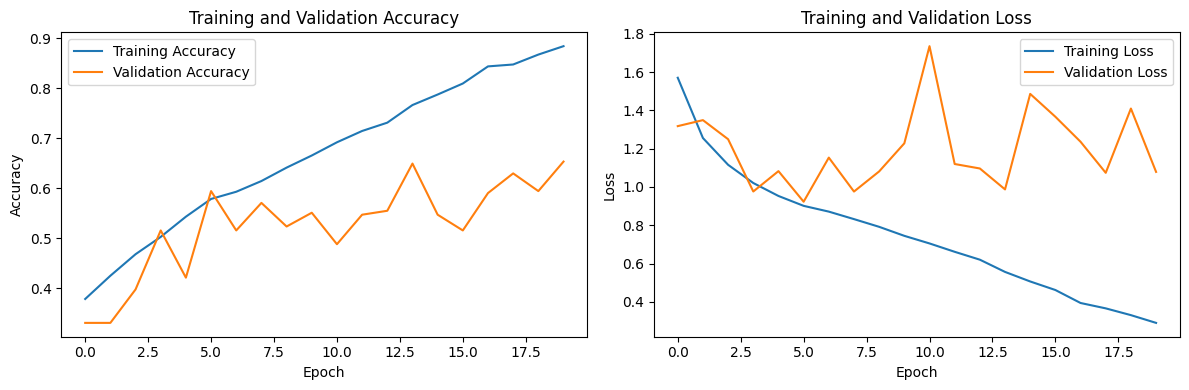

In [52]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [53]:
# Confusion matrix function
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.xticks(rotation=45)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

8/8 [==============================] - 2s 239ms/step


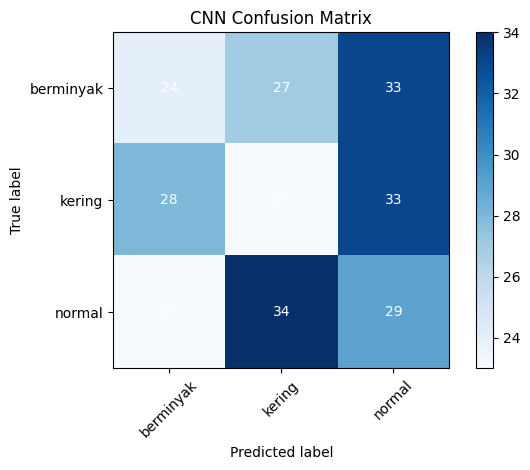

In [54]:
# Validate the model
val_generator.reset()
y_val_pred = model.predict(val_generator)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
val_labels_true = np.argmax(val_labels, axis=1)
class_names = list(train_df['Label'].unique())
plot_confusion_matrix(val_labels_true, y_val_pred_labels, classes=class_names, title='CNN Confusion Matrix')
plt.show()

In [55]:
# Evaluate the model on the validation set
val_generator.reset()
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc}')

8/8 [==============================] - 2s 246ms/step - loss: 1.0787 - accuracy: 0.6535
Validation Accuracy: 0.6535432934761047


8/8 [==============================] - 2s 247ms/step


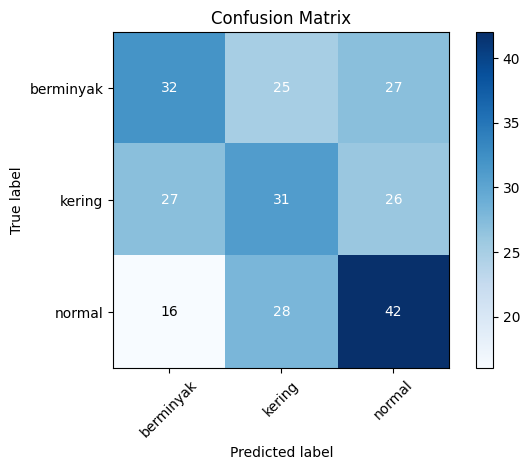

In [56]:
# Generate predictions
val_generator.reset()
y_val_pred = model.predict(val_generator)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
val_labels_true = np.argmax(val_labels, axis=1)

# Plot confusion matrix
plot_confusion_matrix(val_labels_true, y_val_pred_labels, classes=class_names, title='Confusion Matrix')
plt.show()

In [57]:
# Classification report
print("Classification Report:")
print(classification_report(val_labels_true, y_val_pred_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   berminyak       0.43      0.38      0.40        84
      kering       0.37      0.37      0.37        84
      normal       0.44      0.49      0.46        86

    accuracy                           0.41       254
   macro avg       0.41      0.41      0.41       254
weighted avg       0.41      0.41      0.41       254



In [58]:
# Test generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'skin2_split/test/',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  
)

Found 130 images belonging to 3 classes.


In [59]:
# Evaluate the model on the test set
test_generator.reset()
test_pred = model.predict(test_generator)
y_test_pred_labels = np.argmax(test_pred, axis=1)
test_labels = test_generator.classes
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

9/9 [==============================] - 1s 123ms/step - loss: 1.4249 - accuracy: 0.6000
Test accuracy: 0.6000000238418579


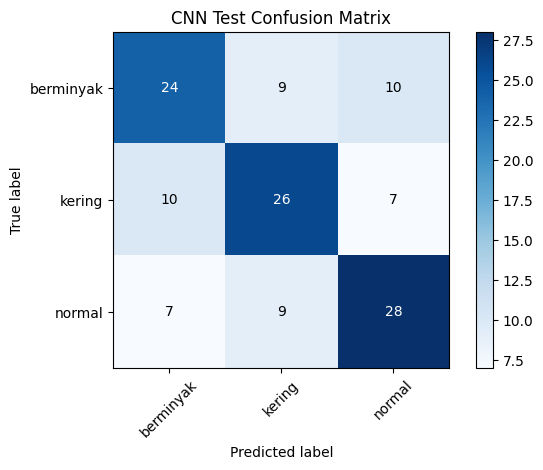

In [60]:
# Plot confusion matrix for test set
plot_confusion_matrix(test_labels, y_test_pred_labels, classes=class_names, title='CNN Test Confusion Matrix')
plt.show()

In [61]:
# Classification report for test data
print("Classification Report for CNN Model on Test Data:")
print(classification_report(test_labels, y_test_pred_labels, target_names=class_names))

Classification Report for CNN Model on Test Data:
              precision    recall  f1-score   support

   berminyak       0.59      0.56      0.57        43
      kering       0.59      0.60      0.60        43
      normal       0.62      0.64      0.63        44

    accuracy                           0.60       130
   macro avg       0.60      0.60      0.60       130
weighted avg       0.60      0.60      0.60       130



1/1 [==============================] - 0s 49ms/step


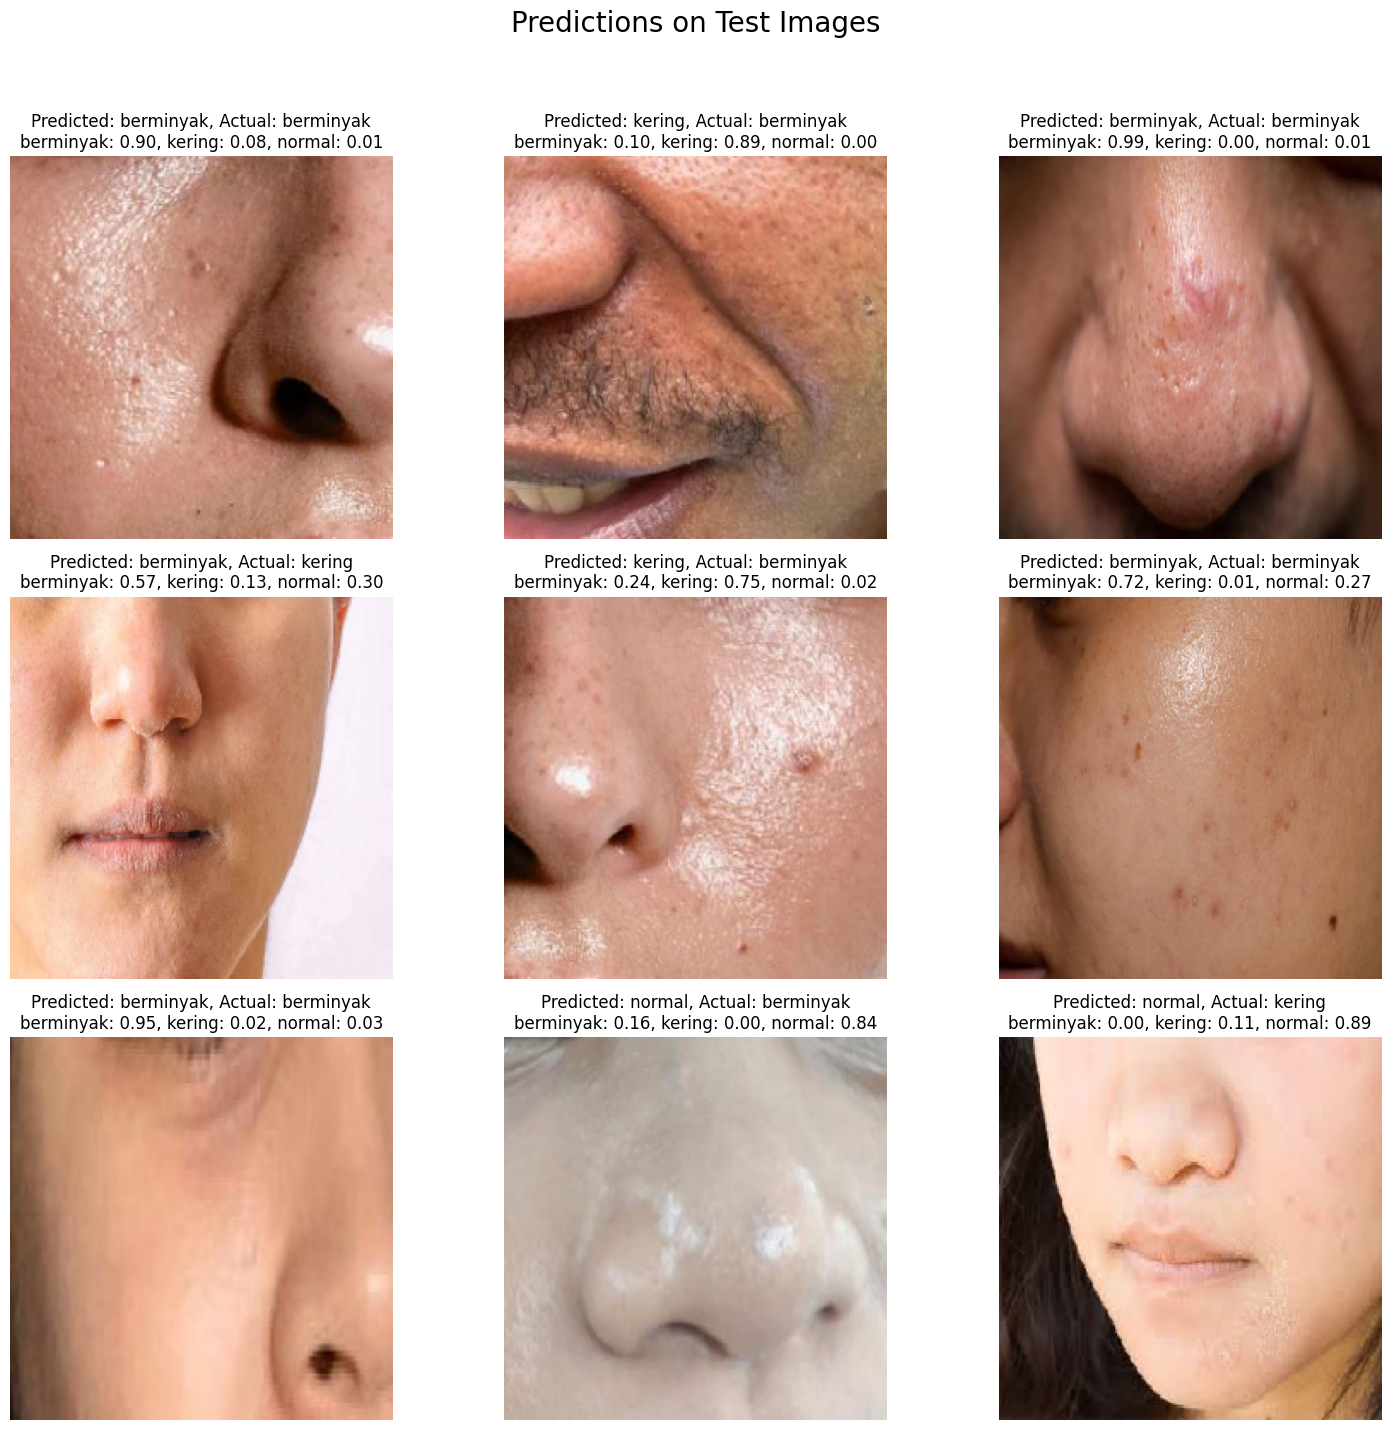

In [62]:
plt.figure(figsize=(15, 15))
plt.suptitle('Predictions on Test Images', fontsize=20)

num_samples = 9
for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    img_index = random.randint(0, len(test_generator.filenames) - 1)
    img_path = test_generator.filenames[img_index]
    
    # Construct the full path to the image
    full_img_path = os.path.join(test_generator.directory, img_path)
    
    img = load_img(full_img_path, target_size=(224, 224))  
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image data
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    
    # Extract the true class label from the directory structure
    true_class = os.path.basename(os.path.dirname(full_img_path))

    labels_str = ', '.join([f'{class_names[j]}: {prediction[0][j]:.2f}' for j in range(len(class_names))])
    plt.title(f'Predicted: {predicted_class}, Actual: {true_class}\n{labels_str}', fontsize=12)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()